In [22]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import auc, roc_auc_score

df = pd.read_csv('train.csv')

In [2]:
#функция для разбиения возрастов по группам согласно гипотезе, приведенной в файле.
#group_size - параметр размера каждой группы
#результаты нужно обязательно подвергуть one-hot encoding, так как зависимость нелинейная
def get_age_group(age):
    group_size = 7
    if age <= 17:
        return 1
    if age > 66:
        age = 66
    return 1 + ((age - 17) // group_size)
print(get_age_group(18), get_age_group(27), get_age_group(45), get_age_group(60), get_age_group(80))

1 2 5 7 8


In [3]:
def get_pdays_group(pdays):
    if pdays == 0 or pdays == 999:
        return 1
    elif 2 <= pdays < 15:
        return 2
    return 3

print (get_pdays_group(999), get_pdays_group(0), get_pdays_group(3), get_pdays_group(20))

1 1 2 3


In [4]:
def preprocessing_optimal(df):
    df = df.drop(["_id", "age", 'job', "marital", "education", "default",
                 "housing", "loan", "day_of_week", 'campaign', 'previous', 'emp.var.rate', "cons.price.idx",
                 "cons.conf.idx", "euribor3m", 'pdays'], axis = 1)
    df = pd.get_dummies(df, columns=['contact', 'month', 'poutcome'])
    return df

def preprocessing_1(df):
    
    df["age_group"] = df["age"].map(get_age_group)
    df['pdays'] = df['pdays'].map(get_pdays_group)
    df = df.drop(["_id", "age", "marital", "default",
                 "housing", "loan", "day_of_week", 'campaign', 'previous', "cons.price.idx",
                 "cons.conf.idx", "euribor3m"], axis = 1)
    df = pd.get_dummies(df, columns=['age_group', 'contact', 'month', 'poutcome', 'pdays', 'job', 'education'])
    return df

def preprocessing(df_input, algorithm = preprocessing_optimal):
    return algorithm(df_input)

In [5]:
from sklearn.preprocessing import StandardScaler
#обрабатываем данные инициализируем X и Y
df_prepared = preprocessing(df)
y = df_prepared['target']
X = StandardScaler().fit_transform(df_prepared.drop('target', axis=1))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12134)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17298, 17) (7414, 17) (17298,) (7414,)


C:\Users\Vera Osipchuk\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [9]:
logreg = LogisticRegression().fit(X_train, y_train)
decision_tree = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)
random_forest = RandomForestClassifier(max_depth = 8).fit(X_train, y_train)


In [11]:
model = logreg
lst = list()
for i in range (1,21):
    lst.append(roc_auc_score(y_test, 
        [ 1 if y > (0.02 * i) else 0 for y in model.predict_proba(X_test)[:,1]]))
max(lst)

0.86484998646369338

In [15]:
model = decision_tree
lst = list()
for i in range (1,21):
    lst.append(roc_auc_score(y_test, 
        [ 1 if y > (0.02 * i) else 0 for y in model.predict_proba(X_test)[:,1]]))
max(lst)

0.86860267841555938

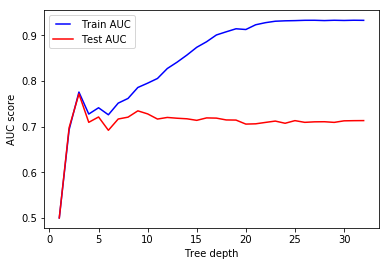

In [24]:
#определяем оптимальную глубину

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [42]:
#определяем оптимальную метрику

metrics_list = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
comparison_metrics = []

for i in metrics_list:
    knn = KNeighborsClassifier(n_neighbors=5, metric=i).fit(X_train, y_train)
    
    model = knn
    lst = list()
    for i in range (1,21):
        lst.append(roc_auc_score(y_test, 
                                 [ 1 if y > (0.02 * i) else 0 for y in model.predict_proba(X_test)[:,1]]))
    comparison_metrics.append(max(lst))
    
comparison_metrics

[0.84642817906239542,
 0.84469907812359191,
 0.84567458791954553,
 0.84642817906239542]

In [48]:
#определяем оптимальное количество соседей
neighbors_list = np.linspace(1, 100, 10, endpoint=True, dtype=int)
comparison_neighbors = []

for k in neighbors_list:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski').fit(X_train, y_train)
    
    model = knn
    lst = list()
    for i in range (1,21):
        lst.append(roc_auc_score(y_test, 
                                 [ 1 if y > (0.02 * int(i)) else 0 for y in model.predict_proba(X_test)[:,1]]))
    comparison_neighbors.append(max(lst))
    
comparison_neighbors

[0.71261150544020602,
 0.85675607941031795,
 0.8721890227773722,
 0.87655738361198399,
 0.8743916659491785,
 0.87721847818278231,
 0.87474044748964119,
 0.87650391474375255,
 0.87661085248021509,
 0.87597946283621175]

(-0.01, 1.01)

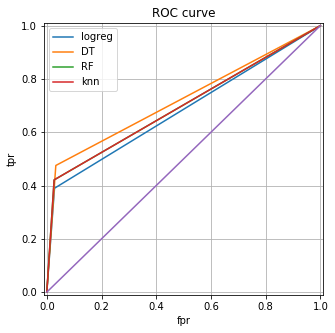

In [33]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict(X_test))
fpr2, tpr2, thresholds2 = roc_curve(y_test, decision_tree.predict(X_test))
fpr3, tpr3, thresholds3 = roc_curve(y_test, random_forest.predict(X_test))
fpr4, tpr4, thresholds4 = roc_curve(y_test, knn.predict(X_test))
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='logreg')
plt.plot(fpr2, tpr2, label='DT')
plt.plot(fpr3, tpr3, label='RF')
plt.plot(fpr3, tpr3, label='knn')
plt.plot([0, 1], [0, 1])
plt.legend()
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))